# Basic usage of modified transformers library (modification have been done only for BERT)

## Install the changed library (only first once)

cd transformers1. move into the modified library
> $ cd transformers

1. install using pip (I recommend editable mode (-e option).)
> $ pip install -e .

1. please install pytorch (https://pytorch.org/) \
 e.g., 
 > $ pip install torch torchvision

In [14]:
cd transformers

/home/nammu/code/norm-analysis-of-transformer/emnlp2020/transformers


In [15]:
pip install -e .

Obtaining file:///home/nammu/code/norm-analysis-of-transformer/emnlp2020/transformers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for transformers (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.24.0.dev0-0.editable-py3-none-any.whl size=30586 sha256=69fbc57dd48d222936dedb427fb151e87d89f31944e62ca9d119a22ae8fe9818
  Stored in directory: /tmp/pip-ephem-wheel-cache-yv1j_u6l/wheels/5f/f6/2d/85a3e593dec6a2d68624d610aa24f9108451b63f3d577827aa
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.24.0.dev0
    Uninstalling transformers-4.24.0.dev0:
      Successfully uninstalled transformers-4.24.0.dev0
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


## Usage

In [1]:
import torch
import transformers
from transformers import BertModel, BertTokenizer, GPT2Tokenizer, OPTForCausalLM, OPTModel

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/nammu/code/norm-analysis-of-transformer/emnlp2020/venv-norm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install IProgress

In [2]:
# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased").to(device)

model.eval()

# Tokenize text and convert to ids.
input_ids = torch.tensor([tokenizer.encode("Here is some text to encode", add_special_tokens=True)]).to(device)
print(input_ids)
tokenized_text = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokenized_text)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[  101,  2182,  2003,  2070,  3793,  2000,  4372, 16044,   102]])
['[CLS]', 'here', 'is', 'some', 'text', 'to', 'en', '##code', '[SEP]']


In [3]:
# If you want to extract vector norms (i.e., ||f(x)||, ||αf(x)||, ||Σαf(x)||), please set the argument "output_norms" to True.
with torch.no_grad():
    output = model(input_ids=input_ids, output_hidden_states=True, output_attentions=True, output_norms=True)

In [4]:
len(output) #last_hidden_states, pooler_output, attentions, norm_attentions

5

In [5]:
attentions = output.attentions
print(len(attentions))

12


In [6]:
len(output.norm_attentions)

12

In [7]:
norms = output.norm_attentions

In [8]:
# Returned variable "norms" is a tuple which has 12 elements (equal to the number of layers).
print(type(norms))
print(len(norms))

<class 'tuple'>
12


In [9]:
# Each element is a tuple which consists of 3 elements: ||f(x)||, ||αf(x)||, and ||Σαf(x)||.
layer = 5
print(type(norms[layer-1]))
print(len(norms[layer-1]))

fx_norm, afx_norm, summed_afx_norm = norms[layer-1]

<class 'tuple'>
3


In [10]:
# shape of fx_norm (||f(x)||) is (batch, num_heads, seq_length)
print("shape of ||f(x)||:", fx_norm.size())

shape of ||f(x)||: torch.Size([1, 12, 9])


In [11]:
# shape of afx_norm (||αf(x)||) is (batch, num_heads, seq_length, seq_length)
print("shape of ||αf(x)||:", afx_norm.size())

shape of ||αf(x)||: torch.Size([1, 12, 9, 9])


In [12]:
# shape of summed_afx_norm (||Σαf(x)||) is (batch, seq_length, seq_length)
print("shape of ||Σαf(x)||:", summed_afx_norm.size())

shape of ||Σαf(x)||: torch.Size([1, 9, 9])


## Comparison with attention weight

In [13]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set the layer and head you want to check. (layer: 1~12, head: 1~12)
layer = 7
head = 5

### 1a Attention weight visualization (Head-level visualization)

In [26]:
plt.figure() 
attention = attentions[layer-1][0][head-1].cpu().numpy()
df = pd.DataFrame(attention,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

<Figure size 640x480 with 0 Axes>

### 1b Norm of the weighted vectors (||αf(x)||) visualization (Head-level visualization)

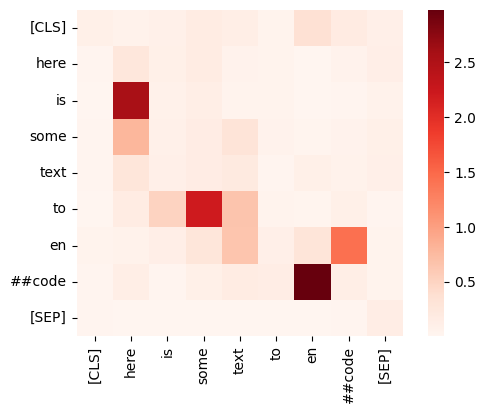

In [15]:
plt.figure() 
afx_norm = norms[layer-1][1]
norm = afx_norm[0][head-1].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### 2a Attention weight visualization (Layer-level visualization)

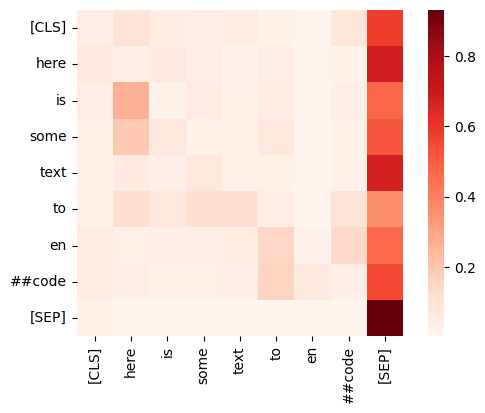

In [16]:
plt.figure() 
attention = attentions[layer-1][0].mean(0).cpu().numpy()
df = pd.DataFrame(attention,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### 2b Norm of the summed weighted vectors (||Σ αf(x)||) visualization (Layer-level visualization)

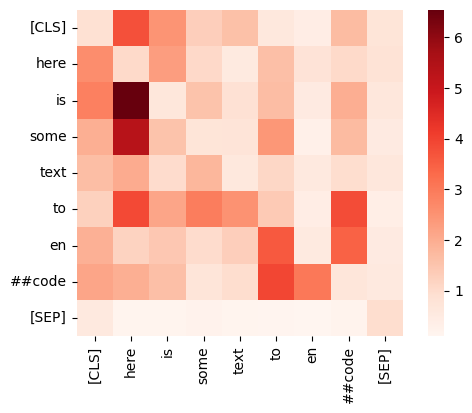

In [17]:
plt.figure() 
summed_afx_norm = norms[layer-1][2]
norm = summed_afx_norm[0].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

In [18]:
# for OPT

In [33]:
import torch
import transformers
from transformers import GPT2Tokenizer, OPTForCausalLM, OPTModel

device = "cuda" if torch.cuda.is_available() else "cpu"

In [34]:
tokenizer = GPT2Tokenizer.from_pretrained("facebook/opt-125m")
model = OPTForCausalLM.from_pretrained("facebook/opt-125m")
model.eval()

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0): OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
            (norm): OPTNormOutput()
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer

In [50]:
prompt = "robot must obey orders given to it"
inputs = tokenizer(prompt, return_tensors="pt").to(device)

In [51]:
outputs = model(**inputs, output_attentions=True, output_norms=True)

4
1
4
2
4
3
4
4
4
5
4
6
4
7
4
8
4
9
4
10
4
11
4
12


In [52]:
len(outputs)

4

In [53]:
len(outputs.norm_attentions)

12

In [54]:
attentions = outputs.attentions
norms = outputs.norm_attentions

In [55]:
# Returned variable "norms" is a tuple which has 12 elements (equal to the number of layers).
print(type(norms))
print(len(norms))

<class 'tuple'>
12


In [56]:
# Each element is a tuple which consists of 3 elements: ||f(x)||, ||αf(x)||, and ||Σαf(x)||.
layer = 5
print(type(norms[layer-1]))
print(len(norms[layer-1]))

fx_norm, afx_norm, summed_afx_norm = norms[layer-1]

<class 'tuple'>
3


In [57]:
# shape of fx_norm (||f(x)||) is (batch, num_heads, seq_length)
print("shape of ||f(x)||:", fx_norm.size())

shape of ||f(x)||: torch.Size([1, 12, 9])


In [58]:
# shape of afx_norm (||αf(x)||) is (batch, num_heads, seq_length, seq_length)
print("shape of ||αf(x)||:", afx_norm.size())

shape of ||αf(x)||: torch.Size([1, 12, 9, 9])


In [59]:
# shape of summed_afx_norm (||Σαf(x)||) is (batch, seq_length, seq_length)
print("shape of ||Σαf(x)||:", summed_afx_norm.size())

shape of ||Σαf(x)||: torch.Size([1, 9, 9])


In [60]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set the layer and head you want to check. (layer: 1~12, head: 1~12)
layer = 7
head = 5

In [61]:
# Tokenize text and convert to ids.
input_ids = torch.tensor([tokenizer.encode(prompt, add_special_tokens=True)]).to(device)
print(input_ids)
tokenized_text = tokenizer.convert_ids_to_tokens(input_ids[0])
print(tokenized_text)

tensor([[    2,  1001, 12749,   531, 28616,  3365,   576,     7,    24]])
['</s>', 'ro', 'bot', 'Ġmust', 'Ġobey', 'Ġorders', 'Ġgiven', 'Ġto', 'Ġit']


### 1a OPT Attention weight visualization (Head-level visualization)

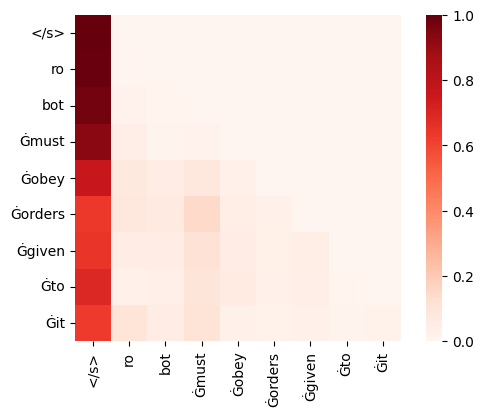

In [62]:
plt.figure() 
attention = attentions[layer-1][0][head-1].detach().numpy()
df = pd.DataFrame(attention,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### 1b OPT Norm of the weighted vectors (||αf(x)||) visualization (Head-level visualization)

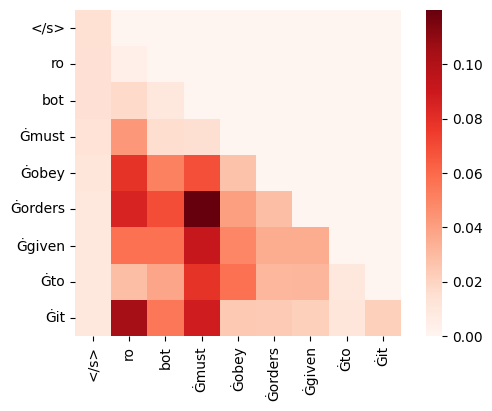

In [63]:
plt.figure() 
afx_norm = norms[layer-1][1]
norm = afx_norm[0][head-1].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### 2a OPT Attention weight visualization (Layer-level visualization)

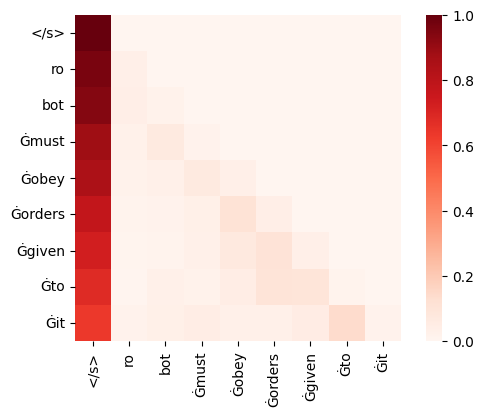

In [64]:
plt.figure() 
attention = attentions[layer-1][0].mean(0).detach().numpy()
df = pd.DataFrame(attention,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### 2b OPT Norm of the summed weighted vectors (||Σ αf(x)||) visualization (Layer-level visualization)

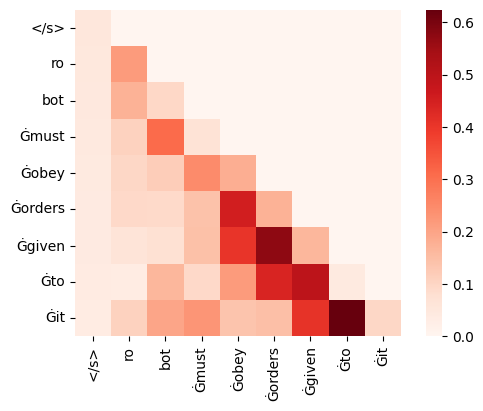

In [65]:
plt.figure() 
summed_afx_norm = norms[layer-1][2]
norm = summed_afx_norm[0].cpu().numpy()
df = pd.DataFrame(norm,columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

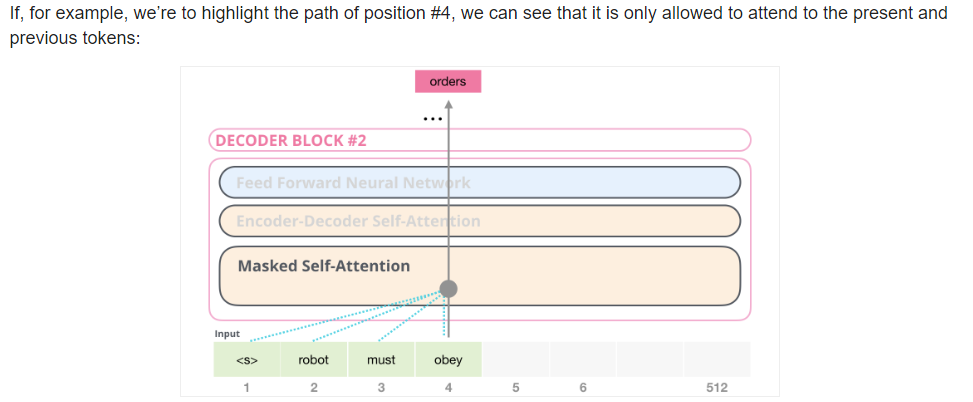

https://jalammar.github.io/illustrated-gpt2/ for understanding attentions in decoder only models